<a href="https://colab.research.google.com/github/eileenrmartin/introClimateDataSci/blob/main/intermediate_climate_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Deliverables:

1. intro to linear regression
2. test of linear regression on ice core data 
3. intro to using linear regression for parameters of other types of functions
4. test of different non-linear regressions on ice core data
5. questions for student exploration

###Introduction

In our previous notebook, we were able to 
* download ice core data that measures the concentration of CO2 on Earth 
* read and visualize that data in several ways
* understand the range of values in different time intervals

We might also want to be able to quantify trends in these data. In this notebook you will learn some foundational tools for quantitatively estimating trends in these data. For example, one might wonder: 
* Is the change in CO2 concentration the same each year (i.e. a linear trend) or does this change vary significantly from year to year (i.e. a non-linear trend)? 
* If these data are following a non-linear trend, could we still find a way to estimate and predict the change?  

**Data Science Learning Goals:** 
1. Understand what it means to fit a function to time series data.
2. Be able to carry out and compare multiple types of regression on the same data. 

**Climate Science Learning Goals:** 
1. Be able to *quantitatively* relate seasonal and long-term trends in atmospheric CO2 to fluxes in the carbon cycle
2. Be able to make approximate predictions about future trends in atmospheric CO2 concentrations

## Basic data reading and cleanup 
#### (repeat from intro notebook)

In [ ]:
import pandas as pd                    # lets us access tools for working with many data values (data frames)
import matplotlib.pyplot as plt        # lets us access tools for plotting
%matplotlib inline                   
# line above ensures that plots are interative (e.g. can zoom with buttons)
import sklearn.linear_model as lm                  # lets us access tools for linear regression

*Grab the ice core data.*

In [ ]:
#Data from 800,000 to 1958
!wget https://www.ncei.noaa.gov/pub/data/paleo/icecore/antarctica/epica_domec/edc-co2-2008.txt

#Data from 1958 to today
!wget https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/monthly/monthly_in_situ_co2_mlo.csv

--2022-06-23 14:12:40--  https://www.ncei.noaa.gov/pub/data/paleo/icecore/antarctica/epica_domec/edc-co2-2008.txt
Resolving www.ncei.noaa.gov (www.ncei.noaa.gov)... 205.167.25.177, 205.167.25.171, 205.167.25.178, ...
Connecting to www.ncei.noaa.gov (www.ncei.noaa.gov)|205.167.25.177|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 107462 (105K) [text/plain]
Saving to: ‘edc-co2-2008.txt’

edc-co2-2008.txt    100%[===================>] 104.94K   182KB/s    in 0.6s    

2022-06-23 14:12:41 (182 KB/s) - ‘edc-co2-2008.txt’ saved [107462/107462]

--2022-06-23 14:12:42--  https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/monthly/monthly_in_situ_co2_mlo.csv
Resolving scrippsco2.ucsd.edu (scrippsco2.ucsd.edu)... 169.228.224.138
Connecting to scrippsco2.ucsd.edu (scrippsco2.ucsd.edu)|169.228.224.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 77907 (76K) [text/csv]
Saving to: ‘monthly_in_situ_co2_mlo.csv’

monthly_in_s

*Read the files you downloaded and store the data in Pandas data frames. One is a text (txt) file and the other is a comma-separated-value (csv) file, so they use different methods to read.*


In [ ]:
# First, read in the txt file
txtFilename = 'edc-co2-2008.txt'
olderData = pd.read_csv(txtFilename, skiprows=773, delimiter=r'\s+')
print(olderData)

      Age(yrBP)  CO2(ppmv)
0           137      280.4
1           268      274.9
2           279      277.9
3           395      279.1
4           404      281.9
...         ...        ...
1091     794608      199.4
1092     795202      195.2
1093     796467      189.3
1094     797099      188.4
1095     798512      191.0

[1096 rows x 2 columns]


In [ ]:
# Now, read in the csv file
csvFilename = 'monthly_in_situ_co2_mlo.csv'
headersRaw = pd.read_csv(csvFilename, skiprows=54, nrows=3, header=None)   # read the headers, with long ones on multiple lines
headers = headersRaw.sum(axis=0)    # add (append) the text for each header that's split across rows
headersClean = [thisHdr.replace(" ","") for thisHdr in list(headers)] # replace spaces with nothing
# print the headers to see what attributes are measured
print("The "+str(headers.size)+" headers are: \n")
print(headersClean)
recentData = pd.read_csv(csvFilename, skiprows=57, names=headersClean)   # read the actual data values
print("The number of (measurement times, attributes) in these data is: "+str(recentData.shape))

     Age(yrBP)    CO2(ppmv)
0       137           280.4
1       268           274.9
2       279           277.9
3       395           279.1
4       404           281.9
...                     ...
1091    794608        199.4
1092    795202        195.2
1093    796467        189.3
1094    797099        188.4
1095    798512          191

[1096 rows x 1 columns]
The 10 headers are: 

['Yr', 'Mn', 'DateExcel', 'Date', 'CO2[ppm]', 'seasonallyadjusted[ppm]', 'fit[ppm]', 'seasonallyadjustedfit[ppm]', 'CO2filled[ppm]', 'seasonallyadjustedfilled[ppm]']
The number of (measurement times, attributes) in these data is: (780, 10)


*We've got to combine these two datasets, and make sure that the new data (standard years) are consistent in reporting their timing with the old data (years before present, with present being 1950).*

In [ ]:
present = 1950
olderData['Date'] = present - olderData['Age(yrBP)']
print("New olderData is: \n")
print(olderData)

New olderData is: 

      Age(yrBP)  CO2(ppmv)    Date
0           137      280.4    1813
1           268      274.9    1682
2           279      277.9    1671
3           395      279.1    1555
4           404      281.9    1546
...         ...        ...     ...
1091     794608      199.4 -792658
1092     795202      195.2 -793252
1093     796467      189.3 -794517
1094     797099      188.4 -795149
1095     798512      191.0 -796562

[1096 rows x 3 columns]


*Let's append the two data frames into a new one that contains all the CO2 ppm data and years. We first need to make sure the header names match for the CO2.*

In [ ]:
olderData.rename(columns={'CO2(ppmv)': 'CO2[ppm]'}, inplace=True)
DateAndCO2 = ['Date', 'CO2[ppm]']
data = pd.concat([olderData[DateAndCO2],recentData[DateAndCO2]])
print(data)

          Date  CO2[ppm]
0    1813.0000    280.40
1    1682.0000    274.90
2    1671.0000    277.90
3    1555.0000    279.10
4    1546.0000    281.90
..         ...       ...
775  2022.6219    -99.99
776  2022.7068    -99.99
777  2022.7890    -99.99
778  2022.8740    -99.99
779  2022.9562    -99.99

[1876 rows x 2 columns]


*Let's take another look at some of our data. What trends do you see?*

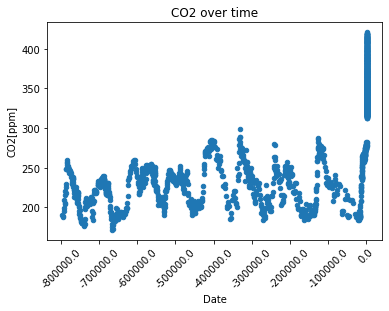

In [ ]:
ax = data.plot.scatter(x='Date',y='CO2[ppm]')
ax.set_title("CO2 over time")
ax.set_xticklabels(ax.get_xticks(), rotation = 45)
plt.show()

*Notice that there are a few valus that don't make any sense, -99.99 parts of CO2 per million? When looking at these points by eye, we can easily just ignore these. But when we want to instruct the computer to automatically analyze these data for trends, we've got to tell it which points to ignore. This is often referred to as* **pre-processing** *or* **data cleaning.** 

*In this case, we want to ignore data points that have a negative CO2 concentration.*

In [ ]:
# first, find the indices of which CO2[ppm] data were junk (negative) values
whereNegative = data[data['CO2[ppm]'] < 0].index # grabs the index of each negative CO2 reading in the data frame 
print("The indices of measurements with negative values are: \n"+str(whereNegative))
# now drop those entries from the data frame
data.drop(whereNegative, inplace=True)

The indices of measurements with negative values are: 
Int64Index([0, 1, 5, 9, 73, 74, 75, 773, 774, 775, 776, 777, 778, 779], dtype='int64')


*Let's plot these data again, now that we've removed the negative values.*

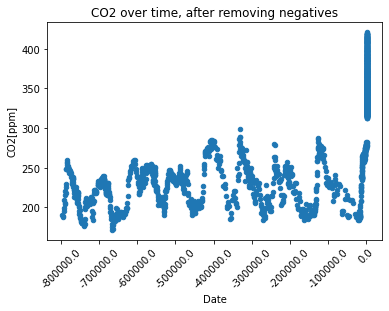

In [ ]:
ax = data.plot.scatter(x='Date',y='CO2[ppm]')
ax.set_title("CO2 over time, after removing negatives")
ax.set_xticklabels(ax.get_xticks(), rotation = 45)
plt.show()

## Linear Regression: A Simple Way to Describe (some) Trends in Data

TO ADD: some text about why we might want to fit data with a line. 

TO ADD: Some basic intro to linear regression.

TO ADD: some links with more info about linear regression.

Linear regression is the simplest type of regression, so we'll start with it, but this tool also forms the basis for other types of regression. 

### A basic test of linear regression

On the long time scale, the CO2 concentration does not appear like it would be fit well by a line. What about if we plot just the recent data, since 1958? 

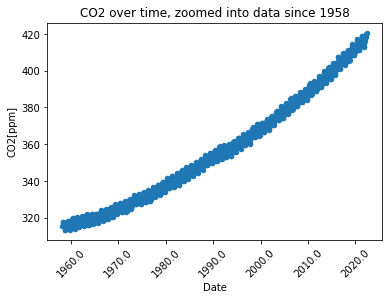

In [ ]:
moreRecentData = data[data['Date'] > 1958]
ax = moreRecentData.plot.scatter(x='Date',y='CO2[ppm]')
ax.set_title("CO2 over time, zoomed into data since 1958")
ax.set_xticklabels(ax.get_xticks(), rotation = 45)
plt.show()

It's not exactly a straight line, but not too far off, so we could start out with this portion of the data to test out linear regression. 

In [ ]:
# Create an object that is capable of linear regression, but isn't connected to our data yet
myLinearRegressor = lm.LinearRegression(fit_intercept=True)
# cast the columns into the kind of arrays that Scikit Learn tools expect
dateArray = moreRecentData['Date'].values.reshape(-1,1)
CO2Array = moreRecentData['CO2[ppm]'].values.reshape(-1,1)
# now fit the data
myLinearRegressor.fit(dateArray,CO2Array)

LinearRegression()

Print the results to see if they make sense. 

In [ ]:
print("The coefficients of the linear model are: ")
print("Slope: "+str(myLinearRegressor.coef_))
print("Intercept: "+str(myLinearRegressor.intercept_))

The coefficients of the linear model are: 
Slope: [[1.60644443]]
Intercept: [-2840.33317533]


This means our predicted CO2 concentration ($y$) in terms of our year ($x$) would be described by: 
$$ y = 1.606 x - 2840.333$$
We know that this can't hold up forever, because it would imply that at year 0 there is a negative CO2 concentration. 

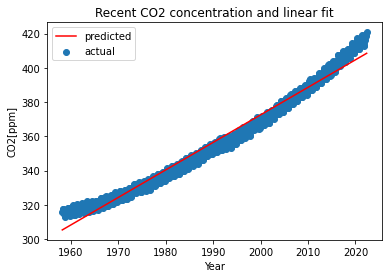

In [ ]:
# plot the original data as a scatter plot
plt.scatter(dateArray,CO2Array,label='actual')
# use the model to predict the linear trend
CO2PredLinear = myLinearRegressor.predict(dateArray)
plt.plot(dateArray,CO2PredLinear,color='r',label='predicted')
plt.xlabel('Year')
plt.ylabel('CO2[ppm]')
plt.legend() 
plt.title('Recent CO2 concentration and linear')
plt.show()

### How do we know if our fit is good? 

TO DO: talk about residuals here, how you want to get a random or inconsistent mix of +/- residuals if the model is a good fit.

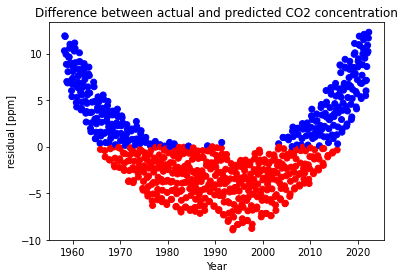

In [ ]:
# calculate the difference between the actual and linearly predicted data
residuals = CO2Array - CO2PredLinear
# assign the color to be blue if the actual data was higher than predicted, red if lower
colorArray = []
for r in residuals:
  if r > 0:
    colorArray.append('b')
  else:
    colorArray.append('r')
plt.scatter(dateArray,residuals,label='actual',color=colorArray)
plt.ylabel('residual [ppm]')
plt.xlabel('Year')
plt.title('Difference between actual and predicted CO2 concentration')
plt.show()

Let's also check out if there are any seasonal trends in the residual based on the month within the year. First, let's just zoom in on our residual plot for a few years. 

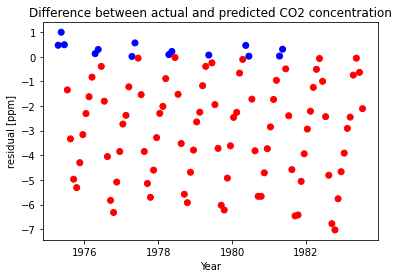

In [ ]:
plt.scatter(dateArray[200:300],residuals[200:300],label='actual',color=colorArray[200:300])
plt.ylabel('residual [ppm]')
plt.xlabel('Year')
plt.title('Difference between actual and predicted CO2 concentration')
plt.show()

**Questions:**

* Based on these residuals and the plot of the linear model alongside the data, what do you notice? 

* Is this model a good fit for the data? 

* Considering the trends that we see in the redisuals, what are some ways we could change the linear model to fit the data better?

### Fitting just the January data

Since we see these seasonal trends, one way to simplify the data as we try to understand changes across years would be to focus on fitting data from the same month each year. We could arbitrarily choose January.